# Fase 4: Feature Engineering Estratégico

Este notebook implementa la ingeniería de variables externas y de negocio para el proyecto **Forecaster Mis Buñuelos**.

**Objetivo:** Generar `data/03_features/master_features.parquet` con variables cíclicas, binarias y retardos de marketing.

In [15]:
# Celda 1: Setup y Configuración
import pandas as pd
import numpy as np
import yaml
from pathlib import Path
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Definir Rutas
BASE_DIR = Path(os.getcwd())
if BASE_DIR.name == "notebooks":
    BASE_DIR = BASE_DIR.parent

CONFIG_PATH = BASE_DIR / "config.yaml"
INPUT_DATA_PATH = BASE_DIR / "data" / "02_cleansed"
OUTPUT_DATA_PATH = BASE_DIR / "data" / "03_features"
ARTIFACTS_PATH = BASE_DIR / "experiments" / "phase_04_feature_engineering" / "artifacts"
FIGURES_PATH = BASE_DIR / "experiments" / "phase_04_feature_engineering" / "figures"

# Crear directorios
OUTPUT_DATA_PATH.mkdir(parents=True, exist_ok=True)
ARTIFACTS_PATH.mkdir(parents=True, exist_ok=True)
FIGURES_PATH.mkdir(parents=True, exist_ok=True)

# Cargar Configuración
with open(CONFIG_PATH, "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)

print("Configuración cargada y rutas establecidas.")

Configuración cargada y rutas establecidas.


In [16]:
# Celda 2: Carga de Datos
input_file = INPUT_DATA_PATH / "master_monthly.parquet"
if not input_file.exists():
    raise FileNotFoundError(f"No se encontró el archivo maestro: {input_file}")

df = pd.read_parquet(input_file)
df.index.name = 'fecha' # Asegurar que el índice tenga nombre si no lo tiene
print(f"Dataset cargado: {df.shape}")
df.head()

Dataset cargado: (97, 18)


,total_unidades_entregadas,unidades_precio_normal,unidades_promo_pagadas,unidades_promo_bonificadas,precio_unitario_full,costo_unitario,ingresos_totales,costo_total,utilidad,inversion_facebook,inversion_instagram,inversion_total,dias_en_promo,ipc_mensual,trm_promedio,tasa_desempleo,costo_insumos_index,confianza_consumidor
fecha,,,,,,,,,,,,,,,,,,
2018-01-01,15786,15786,0,0,600.0,200.0,9471600,3157200.0,6314400.0,0.0,0.0,0.0,0,0.5097,2991.65,11.55,99.37,4.26
2018-02-01,9151,9151,0,0,600.0,200.0,5490600,1830200.0,3660400.0,0.0,0.0,0.0,0,0.4811,2987.70,11.54,101.19,3.73
2018-03-01,10633,10633,0,0,600.0,200.0,6379800,2126600.0,4253200.0,0.0,0.0,0.0,0,0.4955,3051.90,11.32,101.68,7.30
2018-04-01,9289,9289,0,0,600.0,200.0,5573400,1857800.0,3715600.0,0.0,0.0,0.0,0,0.4405,3022.41,11.47,102.42,9.29
2018-05-01,9170,9170,0,0,600.0,200.0,5502000,1834000.0,3668000.0,0.0,0.0,0.0,0,0.5689,3050.18,11.38,104.06,6.98


In [17]:
# Celda 3: Variables Cíclicas (Seno/Coseno)
print("Generando variables cíclicas...")
fe_config = config.get('feature_engineering', {})
cyclical_cols = fe_config.get('cyclical_columns', [])

if 'month' in cyclical_cols:
    df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
    df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)

if 'quarter' in cyclical_cols:
    df['quarter_sin'] = np.sin(2 * np.pi * df.index.quarter / 4)
    df['quarter_cos'] = np.cos(2 * np.pi * df.index.quarter / 4)

if 'semester' in cyclical_cols:
    # Semestre: (mes-1)//6 + 1 -> 1 o 2
    semester = (df.index.month - 1) // 6 + 1
    df['semester_sin'] = np.sin(2 * np.pi * semester / 2)
    df['semester_cos'] = np.cos(2 * np.pi * semester / 2)

print(f"Columnas cíclicas creadas. Shape actual: {df.shape}")

Generando variables cíclicas...
Columnas cíclicas creadas. Shape actual: (97, 24)


In [18]:
# Celda 4: Banderas Binarias de Negocio
print("Generando banderas binarias...")
biz_events = config.get('business_events', {})

# 4.1 Novenas (Diciembre)
df['is_novenas'] = (df.index.month == 12).astype(int)

# 4.2 Primas (Junio y Diciembre)
primas_months = biz_events.get('primas', {}).get('months', [6, 12])
df['is_primas'] = (df.index.month.isin(primas_months)).astype(int)

# 4.3 Pandemia (Rango configurable)
pandemic_cfg = biz_events.get('pandemic', {})
p_start = pd.to_datetime(pandemic_cfg.get('start_date', '2020-04-01'))
p_end = pd.to_datetime(pandemic_cfg.get('end_date', '2021-12-31'))
df['is_pandemic'] = ((df.index >= p_start) & (df.index <= p_end)).astype(int)

print("Banderas binarias creadas.")

Generando banderas binarias...
Banderas binarias creadas.


In [19]:
# Celda 5: Marketing Estratégico (Lag 1)
print("Generando lag de marketing...")
mkt_lags = fe_config.get('marketing_lags', [])

for cfg in mkt_lags:
    col = cfg['column']
    lag = cfg['lag']
    fill_val = cfg.get('fill_value', 0)
    
    new_col_name = f"{col}_lag_{lag}"
    df[new_col_name] = df[col].shift(lag)
    
    # Aplicar Backfill/Fillna para cumplir con el requisito de "0 nulos"
    df[new_col_name] = df[new_col_name].fillna(fill_val)
    print(f"  - Creada {new_col_name} con fill_value={fill_val}")

print(f"Ingeniería completada. Total columnas: {len(df.columns)}")

Generando lag de marketing...
  - Creada inversion_total_lag_1 con fill_value=0
Ingeniería completada. Total columnas: 28


Generando visualizaciones de validación...


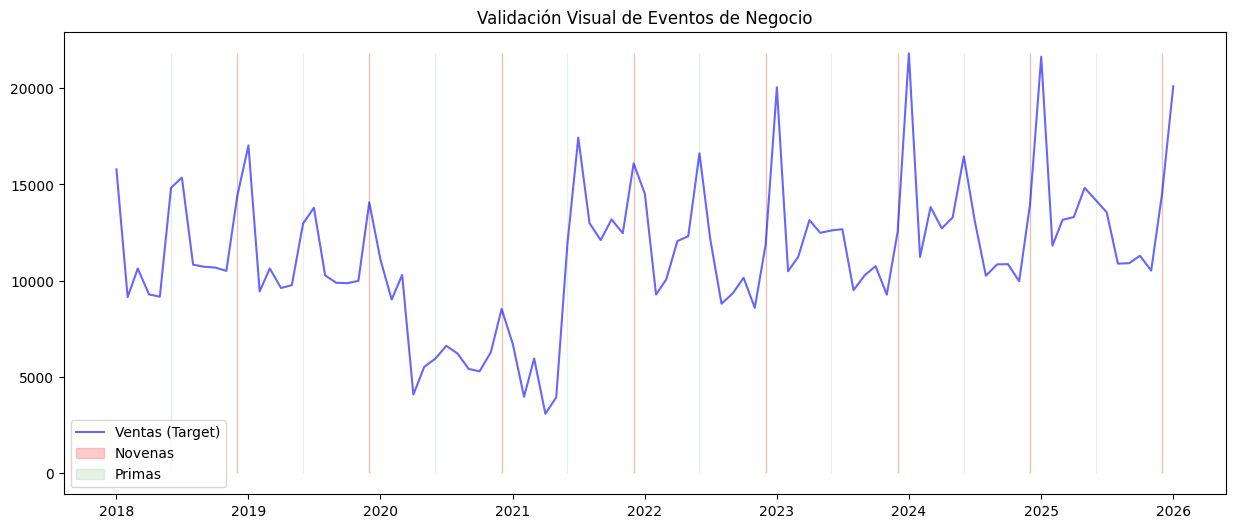

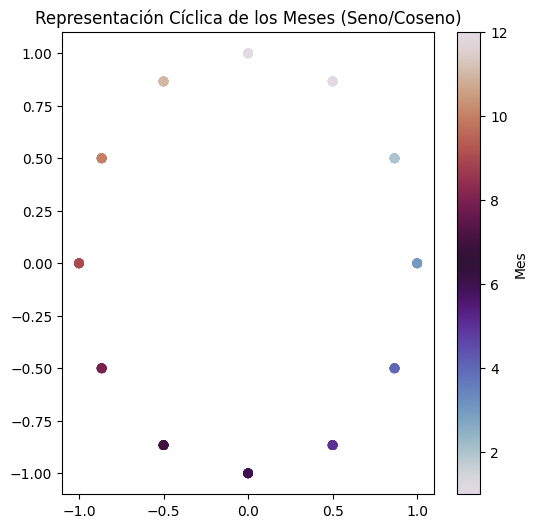

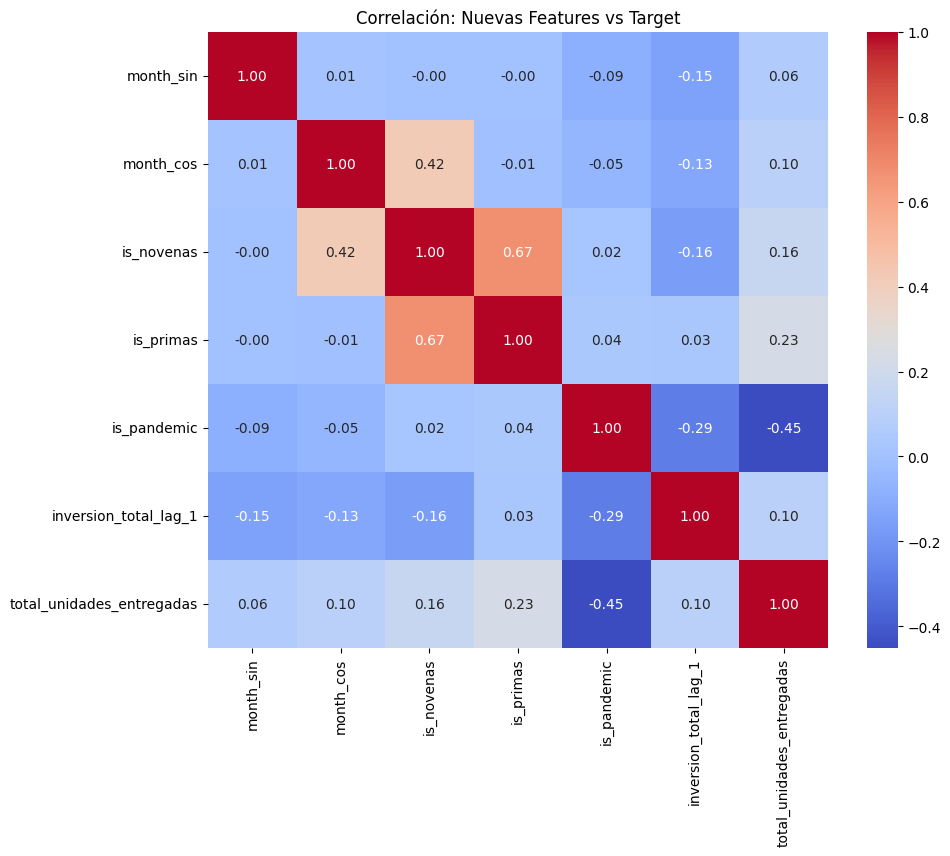

In [20]:
# Celda 6: Validación y Visualización de Laboratorio
print("Generando visualizaciones de validación...")

# 6.1 Visualización de Banderas vs Target
plt.figure(figsize=(15, 6))
plt.plot(df.index, df[config['project']['target_column']], label='Ventas (Target)', color='blue', alpha=0.6)
plt.fill_between(df.index, 0, df[config['project']['target_column']].max(), 
                 where=df['is_novenas']==1, color='red', alpha=0.2, label='Novenas')
plt.fill_between(df.index, 0, df[config['project']['target_column']].max(), 
                 where=df['is_primas']==1, color='green', alpha=0.1, label='Primas')
plt.title("Validación Visual de Eventos de Negocio")
plt.legend()
plt.savefig(FIGURES_PATH / "01_validacion_eventos.png")
plt.show()

# 6.2 Visualización de Ciclos (Month Sin/Cos)
plt.figure(figsize=(6, 6))
plt.scatter(df['month_sin'], df['month_cos'], c=df.index.month, cmap='twilight')
plt.title("Representación Cíclica de los Meses (Seno/Coseno)")
plt.colorbar(label='Mes')
plt.savefig(FIGURES_PATH / "02_ciclos_mensuales.png")
plt.show()

# 6.3 Correlación de Features Nuevas
new_cols = ['month_sin', 'month_cos', 'is_novenas', 'is_primas', 'is_pandemic', 'inversion_total_lag_1']
corr = df[new_cols + [config['project']['target_column']]].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlación: Nuevas Features vs Target")
plt.savefig(FIGURES_PATH / "03_correlacion_features.png")
plt.show()

In [21]:
# Celda 7: Exportación de Resultados y Reporte Robusto
import json
print("Exportando datos y generando reporte robusto...")
output_file = OUTPUT_DATA_PATH / "master_features.parquet"
df.to_parquet(output_file)

# Identificar columnas
# Se asume que 'original_cols' son las columnas antes de este notebook
# Para este ejemplo, se definen las columnas originales de forma explícita o se cargan de un estado anterior
# Si no se tiene un estado anterior, se puede inferir las nuevas columnas de otra manera.
# Para mantener la robustez, se puede guardar la lista de columnas originales en el config o un artefacto previo.
# Aquí, para simplificar, se asume que 'original_cols' es una lista predefinida o cargada.
# En un flujo real, 'original_cols' debería venir del reporte de la fase anterior.
original_cols = [col for col in df.columns if col not in ['month_sin', 'month_cos', 'quarter_sin', 'quarter_cos', 'semester_sin', 'semester_cos', 'is_novenas', 'is_primas', 'is_pandemic'] and not col.endswith('_lag_1')]
new_cols = [c for c in df.columns if c not in original_cols]

# Muestra de datos para el JSON (orientado a registros)
data_preview = {
    "head_5": df.head(5).reset_index().astype(str).to_dict(orient='records'),
    "tail_5": df.tail(5).reset_index().astype(str).to_dict(orient='records'),
    "sample_5": df.sample(min(5, len(df)), random_state=config['project']['random_state']).reset_index().astype(str).to_dict(orient='records')
}

# Generar Reporte JSON Robusto
report = {
    "phase": "Phase 4 - Feature Engineering",
    "timestamp": datetime.now().isoformat(),
    "input_file": "master_monthly.parquet",
    "output_file": "master_features.parquet",
    "variables": {
        "original_columns": original_cols,
        "new_features": {col: str(df[col].dtype) for col in new_cols}
    },
    "summary": {
        "total_rows": len(df),
        "total_columns": len(df.columns),
        "new_features_count": len(new_cols),
        "nulls_check": int(df.isnull().sum().sum()),
        "temporal_range": [df.index.min().isoformat(), df.index.max().isoformat()]
    },
    "data_preview": data_preview
}

with open(ARTIFACTS_PATH / "phase_04_feature_engineering.json", "w") as f:
    json.dump(report, f, indent=4)

print(f"✅ Fase completada exitosamente. Archivo guardado en: {output_file}")

Exportando datos y generando reporte robusto...
✅ Fase completada exitosamente. Archivo guardado en: c:\Users\USUARIO\Documents\Forecaster\Forecaster_MisBunuelos\data\03_features\master_features.parquet
